# Setting Develop Environment

## 코랩 환경에서 사용하는 경우

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/BERT_BMC/'

/content/drive/MyDrive/Colab Notebooks/BERT_BMC


In [3]:
import os
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/BERT_BMC


In [4]:
!ls

BMC_analysis.ipynb  data  font	KoBERT	pytorch-xla-env-setup.py  result


In [ ]:
!nvidia-smi

## 주요 라이브러리 설치

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!git clone https://github.com/SKTBrain/KoBERT.git

In [19]:
!cd KoBERT

In [ ]:
!pip install -r requirements.txt
!pip install .

In [21]:
!cd ..

In [5]:
!pip install transformers==3

     |████████████████████████████████| 757kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 7.9MB/s 
     |████████████████████████████████| 3.0MB 18.0MB/s 
     |████████████████████████████████| 890kB 34.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c7b1cbac525c9b8c56466397588b87ac24d24fc197003e141532ce44ad693b92
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
!pip install gluonnlp

     |████████████████████████████████| 348kB 6.0MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595680 sha256=dd36f4101dc09ac6c0f66830fa6ee0c52be7eebc01db73e86b68bae16cb7d9ca
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp


In [7]:
!pip install mxnet

     |████████████████████████████████| 54.7MB 95kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [8]:
!pip install sentencepiece

# Library Import

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset

In [7]:
from KoBERT.kobert.utils import get_tokenizer
from KoBERT.kobert.pytorch_kobert import get_pytorch_kobert_model

In [5]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [8]:
import gluonnlp as nlp

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm import tqdm, tqdm_notebook
import sys

# Main

In [11]:
%matplotlib inline

In [12]:
plt.style.use('seaborn')
fm.get_fontconfig_fonts()
font_location = '/content/drive/MyDrive/Colab Notebooks/BERT_BMC/font/NanumGothic.ttf'
fprop = fm.FontProperties(fname=font_location)

In [306]:
import random
random.seed(1004)

In [307]:
num_class = 5

In [308]:
device = torch.device("cuda:0")

# import torch_xla
# import torch_xla.core.xla_model as xm

# net = torchvision.models.alexnet(num_classes=num_class)

# # Acquires the default Cloud TPU core and moves the model to it
# device = xm.xla_device()
# net = net.to(device)

In [309]:
bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [310]:
## Setting parameters
batch_size = 16
num_epochs = 30
learning_rate = 5e-5
drop_out_rate = 0.1
test_ratio = 0.3
max_len = 128

In [311]:
filename = '핵심활동'

In [312]:
class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, max_len, pad, pair, filename=filename):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        sent_data = []
        for i in range(len(dataset)):
            sent_data.append([str(dataset.iloc[i][filename]), dataset.iloc[i]['label']])

        self.sentences = [transform([i[0]]) for i in sent_data]
        self.labels = [np.int32(i[1]) for i in sent_data]

    def __getitem__(self, i):
        return self.sentences[i] + (self.labels[i],)

    def __len__(self):
        return len(self.labels)


class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=num_class,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(),
                              attention_mask=attention_mask.float().to(token_ids.device))

        if self.dr_rate:
            out = self.dropout(pooler)
        softmax = nn.Softmax(dim=1)
        output = softmax(self.classifier(out))
        # output = self.classifier(out)
        # return self.classifier(out)
        return output

In [313]:
def read_data(path='./', filename=filename):
    df = pd.read_csv(path + '/' + filename + '.csv', sep=',')
    df = df.dropna(axis=0)

    if num_class == 5:
        df['label'] = df['label'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})
        df['label'] = pd.get_dummies(df.label).values[:, ::-1].tolist()  # one hot encoding
    elif num_class == 2:
        df = df.drop(df[df['label'] == 'C'].index)
        df['label'] = df['label'].replace({'A': 1, 'B': 1, 'D': 0, 'E': 0})
        df = df.dropna(axis=0)
    elif num_class == 3:
        df['label'] = df['label'].replace({'A': 0, 'B': 0, 'C': 1, 'D': 2, 'E': 2})
        # df['label'] = df['label'].replace({'A': 0, 'B': 1, 'C': 2})
        df['label'] = pd.get_dummies(df.label).values[:, ::-1].tolist()  # one hot encoding
    else:
        print('wrong input\n')
        sys.exit()
    return df

In [314]:
def one_hot_ce_loss(outputs, targets):
    criterion = nn.CrossEntropyLoss()
    _, labels = torch.max(targets, dim=1)
    return criterion(outputs, labels)

In [315]:
def model(data=None, num_epochs=10, batch_size=16, test_ratio=0.3, drop_out_rate=0.5,
          learning_rate=5e-5, graph=None, savemode=False, filename=filename):
    x_train, x_test, y_train, y_test = train_test_split(data[filename],
                                                        data['label'],
                                                        test_size=test_ratio,
                                                        shuffle=True,
                                                        stratify=data['label'],
                                                        random_state=1)
    df_train = pd.DataFrame()
    df_train[filename] = x_train
    df_train['label'] = y_train
    df_test = pd.DataFrame()
    df_test[filename] = x_test
    df_test['label'] = y_test

    model = BERTClassifier(bertmodel, dr_rate=drop_out_rate).to(device)

    data_train = BERTDataset(df_train, tok, max_len, True, False)
    data_test = BERTDataset(df_test, tok, max_len, True, False)

    train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
    test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    t_total = len(train_dataloader) * num_epochs
    warmup_step = int(t_total * 0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

    train_acc_list = []
    test_acc_list = []
    train_loss_list = []
    test_loss_list = []

    for e in range(num_epochs):
        train_acc = 0.
        test_acc = 0.
        train_loss = 0.
        test_loss = 0.

        model.train()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
            optimizer.zero_grad()
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length = valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            if num_class == 5:
                loss = one_hot_ce_loss(out, label)
            elif num_class == 2:
                loss = loss_fn(out, label)
            elif num_class == 3:
                loss = one_hot_ce_loss(out, label)
            else:
                print('wrong loss function\n')
                sys.exit()
            train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            # train_acc += calc_accuracy_2(out, label)
            if num_class == 5:
                train_acc += calc_accuracy_1(out, label)
            elif num_class == 2:
                train_acc += calc_accuracy(out, label)
            elif num_class == 3:
                train_acc += calc_accuracy_3(out, label)

            else:
                print('wrong calc accuracy\n')
                sys.exit()

        print("epoch {} train acc {}".format(e + 1, train_acc / (batch_id + 1)))
        train_acc_list.append(train_acc / (batch_id + 1))
        train_loss_list.append(train_loss / (batch_id + 1))

        model.eval()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length = valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)  # softmax output
            # for idx in range(len(out)):
            #     sum = np.dot(out[idx].tolist(), [1, 2, 3, 4, 5]) * 20.
            #     print(sum)

            if num_class == 5:
                loss = one_hot_ce_loss(out, label)
            elif num_class == 2:
                loss = loss_fn(out, label)
            elif num_class == 3:
                loss = one_hot_ce_loss(out, label)
            else:
                print('wrong loss function\n')
                sys.exit()

            test_loss += loss.item()

            if num_class == 5:
                test_acc += calc_accuracy_1(out, label)
            elif num_class == 2:
                test_acc += calc_accuracy(out, label)
            elif num_class == 3:
                test_acc += calc_accuracy_3(out, label)
            else:
                print('wrong calc accuracy\n')
                sys.exit()

        print("epoch {} test acc {}".format(e + 1, test_acc / (batch_id + 1)))
        test_acc_list.append(test_acc / (batch_id + 1))
        test_loss_list.append(test_loss / (batch_id + 1))

    if graph:
        train_x_values = range(1, len(train_acc_list) + 1)
        train_y_values = train_acc_list
        test_x_values = range(1, len(test_acc_list) + 1)
        test_y_values = test_acc_list
        train_loss_x_values = range(1, len(train_loss_list) + 1)
        train_loss_y_values = train_loss_list
        test_loss_x_values = range(1, len(test_loss_list) + 1)
        test_loss_y_values = test_loss_list

        plt.figure(1)
        plt.plot(train_x_values, train_y_values, label='train accuracy')
        plt.plot(test_x_values, test_y_values, label='test accuracy')
        plt.xlabel('epoch', fontproperties=fprop, fontsize=15)
        plt.ylabel('accuracy', fontproperties=fprop, fontsize=15)
        plt.ylim(0.0, 1.1)
        plt.title(filename + ' accuracy', fontproperties=fprop, fontsize=20)
        # plt.title(file, fontsize=20)
        plt.legend()
        plt.savefig('./result/' + filename + '_accuracy.png')

        plt.figure(2)
        plt.plot(train_loss_x_values, train_loss_y_values, label='train loss')
        plt.plot(test_loss_x_values, test_loss_y_values, label='test loss')
        plt.xlabel('epoch', fontproperties=fprop, fontsize=15)
        plt.ylabel('loss', fontproperties=fprop, fontsize=15)
        plt.title(filename + ' loss', fontproperties=fprop, fontsize=20)
        # plt.title(file, fontsize=20)
        plt.legend()
        plt.savefig('./result/' + filename + '_loss.png')

    if savemode:
        torch.save(model.state_dict(), './' + filename)

In [316]:
# 5 class accuracy
def calc_accuracy_1(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    # print('X=', X)
    # print('max_vals=', max_vals)
    # print('max_indices = ', max_indices)
    encoding = []
    # for i in range(len(Y)):
    #     if int(max_indices[i]) == 0:
    #         encoding.append([0, 0, 0, 0, 1])
    #     elif int(max_indices[i]) == 1:
    #         encoding.append([0, 0, 0, 1, 0])
    #     elif int(max_indices[i]) == 2:
    #         encoding.append([0, 0, 1, 0, 0])
    #     elif int(max_indices[i]) == 3:
    #         encoding.append([0, 1, 0, 0, 0])
    #     elif int(max_indices[i]) == 4:
    #         encoding.append([1, 0, 0, 0, 0])

    for i in range(len(Y)):
        if int(max_indices[i]) == 0:
            encoding.append([1, 0, 0, 0, 0])
        elif int(max_indices[i]) == 1:
            encoding.append([0, 1, 0, 0, 0])
        elif int(max_indices[i]) == 2:
            encoding.append([0, 0, 1, 0, 0])
        elif int(max_indices[i]) == 3:
            encoding.append([0, 0, 0, 1, 0])
        elif int(max_indices[i]) == 4:
            encoding.append([0, 0, 0, 0, 1])

    encoding = torch.tensor(encoding).to(device)

    cor_matrix = (encoding == Y).tolist()
    correct = 0.

    for j in range(len(Y)):
        if all(cor_matrix[j]):
            correct += 1.

    #     train_acc = (encoding == Y).sum().data.cpu().numpy()/len(encoding)
    train_acc = correct / len(Y)
    #     train_acc = (encoding == Y).sum().float()/Y.size(0)
    return train_acc

In [317]:
# 3 class accuracy
def calc_accuracy_3(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    encoding = []
    # for i in range(len(Y)):
    #     if int(max_indices[i]) == 0:
    #         encoding.append([0, 0, 1])
    #     elif int(max_indices[i]) == 1:
    #         encoding.append([0, 1, 0])
    #     elif int(max_indices[i]) == 2:
    #         encoding.append([1, 0, 0])
    for i in range(len(Y)):
        if int(max_indices[i]) == 0:
            encoding.append([1, 0, 0])
        elif int(max_indices[i]) == 1:
            encoding.append([0, 1, 0])
        elif int(max_indices[i]) == 2:
            encoding.append([0, 0, 1])
    encoding = torch.tensor(encoding).to(device)

    cor_matrix = (encoding == Y).tolist()
    correct = 0.

    for j in range(len(Y)):
        if all(cor_matrix[j]):
            correct += 1.

    #     train_acc = (encoding == Y).sum().data.cpu().numpy()/len(encoding)
    train_acc = correct / len(Y)
    #     train_acc = (encoding == Y).sum().float()/Y.size(0)
    return train_acc

In [318]:
# 2 class accuracy
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

epoch 1 train acc 0.33049242424242425
epoch 1 test acc 0.37857142857142856
epoch 2 train acc 0.3816287878787879
epoch 2 test acc 0.37857142857142856
epoch 3 train acc 0.39583333333333337
epoch 3 test acc 0.4303571428571429
epoch 4 train acc 0.5181818181818182
epoch 4 test acc 0.45714285714285713
epoch 5 train acc 0.5668560606060606
epoch 5 test acc 0.5133928571428571
epoch 6 train acc 0.6352272727272728
epoch 6 test acc 0.46964285714285714
epoch 7 train acc 0.6922348484848485
epoch 7 test acc 0.45714285714285713
epoch 8 train acc 0.7234848484848485
epoch 8 test acc 0.5008928571428571
epoch 9 train acc 0.6890151515151515
epoch 9 test acc 0.4946428571428571
epoch 10 train acc 0.6206439393939394
epoch 10 test acc 0.5116071428571429
epoch 11 train acc 0.6893939393939393
epoch 11 test acc 0.5651785714285714
epoch 12 train acc 0.8026515151515152
epoch 12 test acc 0.5071428571428571
epoch 13 train acc 0.7831439393939394
epoch 13 test acc 0.5196428571428571
epoch 14 train acc 0.834469696969697

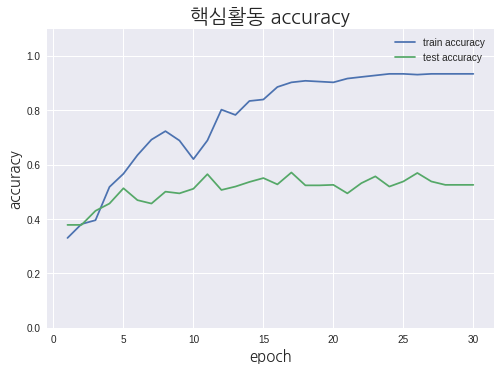

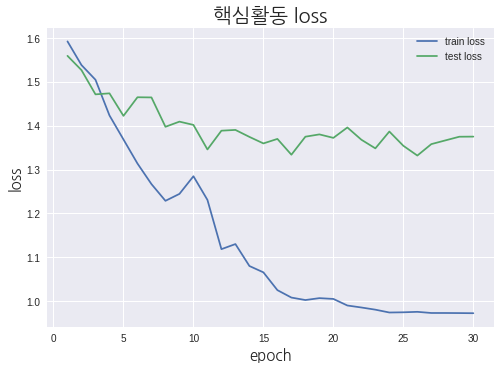

In [319]:
if __name__ == '__main__':

    data = read_data(path='./data/')

    ## exectue model
    model(data=data, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, drop_out_rate=drop_out_rate, test_ratio=test_ratio, graph=True, savemode=False)